In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_curve,
    precision_recall_curve, 
    roc_auc_score,
)
import pickle

# Import models

In [64]:
svm = pickle.load(open('../models/svm.pkl', 'rb'))
lr = pickle.load(open('../models/lr.pkl', 'rb'))
rf = pickle.load(open('../models/rf.pkl', 'rb'))
xgb = pickle.load(open('../models/xgb.pkl', 'rb'))
ensemble = pickle.load(open('../models/ensemble.pkl', 'rb'))

# Import data

In [65]:
val_df = pd.read_csv('../data/val_df.csv')
test_df = pd.read_csv('../data/test_df.csv')

X_val = val_df.drop(columns=["default"])
y_val = val_df["default"]



# Model comparison

In [66]:
#ROC dict for TPR and FPR values
roc_dict = {}
#precision recall curve
prc_dict = {}

def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for ROC metrics
    """
    
    fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    
    clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds}
    
    dict_modify[name] = clf_roc_dict
    
def modify_prc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for precision recall metrics
    """
    
    precision, recall, thresholds = precision_recall_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    clf_prc_dict = {'precision':precision, 'recall': recall, 'thresholds': thresholds}
    
    dict_modify[name] = clf_prc_dict

In [67]:
models = {'SVM': svm, 'Logistic Regression': lr, 'Random Forest': rf, 'XGBoost': xgb, 'Ensemble model': ensemble}

In [68]:
#metrics for lr
for key, value in models.items():
    modify_roc_dict(clf=value,
                    y_test=y_val,
                    X_test=X_val,
                    name=key, 
                    dict_modify=roc_dict)
    modify_prc_dict(clf=value,
                    y_test=y_val,
                    X_test=X_val,
                    name=key,
                    dict_modify=prc_dict)

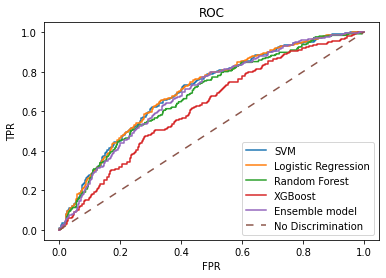

In [69]:
for key in roc_dict:
    clf = roc_dict[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.savefig('../images/roc_curve_all_models.png')
plt.legend()
plt.show()

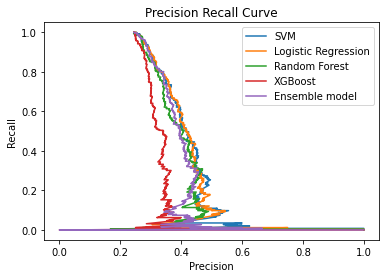

In [70]:
for key in prc_dict:
    clf = prc_dict[key]
    plt.plot(clf['precision'], clf['recall'], label=key)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.savefig('../images/prc_curve_all_models.png')

plt.legend()

plt.show()

The above two graphs show the ROC Curve and Precision-Recall Curve for all the mentioned models. SVM and Logistics Regression are the best performers on the data set as they give the highest AUC score.

In [71]:
scoring = ["accuracy", "f1", "recall", "precision", "roc_auc", "average_precision"]
models = {'svm':svm, 'lr':lr, 'rf':rf, 'xgb':xgb, 'ensemble':ensemble}

In [72]:
data = {"model":[], "roc_auc_score":[], "f1_score":[], 'recall':[], 'precision':[]}

for name, model in models.items():
    data["model"].append(name)
    data['roc_auc_score'].append(roc_auc_score(y_val, model.predict(X_val)))
    data['f1_score'].append(f1_score(y_val, model.predict(X_val)))
    data['recall'].append(recall_score(y_val, model.predict(X_val)))
    data['precision'].append(precision_score(y_val, model.predict(X_val)))

In [73]:
pd.DataFrame(data)

,model,roc_auc_score,f1_score,recall,precision
0,svm,0.650844,0.476858,0.664062,0.371991
1,lr,0.654573,0.480797,0.660156,0.378076
2,rf,0.637508,0.465686,0.742188,0.339286
3,xgb,0.530086,0.211957,0.152344,0.348214
4,ensemble,0.552024,0.256831,0.183594,0.427273


The metric used to determine the best model for the dataset is the AUC score as it worked well for an imbalanced dataset problem. Therefore Logistic Regression is the best preforming model, and will be our final model for submission